In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge_2

Mounted at /gdrive
/gdrive/My Drive/Challenge_2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

plt.rc("font", size=16)
from sklearn.preprocessing import MinMaxScaler, RobustScaler

2.15.0


In [ ]:
WINDOW_SIZE = 100
STRIDE = 5
TELESCOPE = 18

In [ ]:
# 48000 time series of length 2776
dataset = np.load('training_data.npy', allow_pickle=True)
print(dataset.shape)


# containing for each of the time series the start and end index of the current series, i.e. the part without padding
valid_periods = np.load('valid_periods.npy', allow_pickle=True)
print(valid_periods.shape)


categories = np.load('categories.npy', allow_pickle=True)
print(categories.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [ ]:
def createNewDatasetByCategory(dataset, categories, category, validPeriods):
  newDataset = []
  newValidPeriods = []
  idxs = [i for i, x in enumerate(categories) if x == category]
  for idx in idxs:
    newDataset.append(dataset[idx])
    newValidPeriods.append(validPeriods[idx])
  return newDataset, newValidPeriods

In [ ]:
dataset_A, valid_periods_A = createNewDatasetByCategory(dataset , categories, 'A', valid_periods)
print(valid_periods_A[0])

[2536 2776]


In [ ]:
# Extract the non zero part of the time series
def extract_current_serie(time_serie, valid_period):
  start = valid_period[0]
  end = valid_period[1]
  return time_serie[start:end]

In [ ]:
# Transformer la série en un dataFrame d'une colonne
def create_column_dataframe(time_serie):
  transposed_array = np.transpose(time_serie)
  return pd.DataFrame(transposed_array)

In [ ]:
def build_sequences(df, target_labels, window=100, stride=20, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
# Create 3 dim array
X = np.empty((0, WINDOW_SIZE, 1))
y = np.empty((0, TELESCOPE, 1))

for i in range(0, len(dataset_A)):
  current_serie = extract_current_serie(dataset_A[i], valid_periods_A[i])

  df = create_column_dataframe(current_serie)
  sequences, label = build_sequences(df, df.columns, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
  if sequences.ndim != X.ndim:
    continue

  robust_scaler = RobustScaler()

  # Reshape the sequences for normalization
  num_sequences, window, num_features = sequences.shape
  sequences_reshaped = sequences.reshape(-1, num_features)

  # Normalize the sequences
  sequences_scaled = robust_scaler.fit_transform(sequences_reshaped)

  # Reshape the sequences back to their original shape
  sequences = sequences_scaled.reshape(num_sequences, window, num_features)

  X = np.concatenate((X, sequences), axis=0)
  y = np.concatenate((y, label), axis=0)
  if len(X) > 20000:
    print("Used", i, "time series.")
    break

print(X.shape, y.shape)

Used 643 time series.
(20052, 100, 1) (20052, 18, 1)


In [ ]:
# Take a random 80% of the raws in X for training and 20% for testing
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16041, 100, 1) (16041, 18, 1) (4011, 100, 1) (4011, 18, 1)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

# Vannila

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding="same", activation="relu", name="conv")(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding="same", name="output_layer")(
        x
    )

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="CONV_LSTM_model"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

## Transformer + attention + lstm

In [ ]:
def build_transformer_attention_model(input_shape, output_shape, num_heads=8, ff_dim=32, num_transformer_blocks=4, mlp_units=[128]):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise, we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units and return sequences
    lstm_out = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add attention mechanism
    attention = tfkl.Attention()([lstm_out, lstm_out])

    # Concatenate attention output and LSTM output
    transformer_input = tfkl.Concatenate(axis=-1)([lstm_out, attention])

    # Transformer Encoder
    x = transformer_input
    for _ in range(num_transformer_blocks):
        x = _build_transformer_block(x, num_heads, ff_dim)

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling1D()(x)

    # MLP Head
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)

    # Output layer for forecasting 18 values
    output_layer = tfkl.Dense(output_shape[0] * output_shape[1], activation="linear", name="output_layer")(x)

    # Reshape the output to the desired shape (18, 1)
    output_layer = tfkl.Reshape(target_shape=output_shape, name="reshaping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="TransformerAttentionModel"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model

def _build_transformer_block(x, num_heads, ff_dim):
    # Ensure num_heads is less than x.shape[-1]
    num_heads = min(num_heads, x.shape[-1])

    # Calculate key_dim based on input shape
    key_dim = x.shape[-1] // num_heads if x.shape[-1] is not None else None

    # Multi-Head Attention
    attn_layer = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        x, x, x
    )
    attn_output = tfkl.Add()([x, attn_layer])
    attn_output = tfkl.LayerNormalization(epsilon=1e-6)(attn_output)

    # Feed Forward Part
    ffn = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attn_output)
    ffn = tfkl.Conv1D(filters=x.shape[-1], kernel_size=1)(ffn)
    x = tfkl.Add()([attn_output, ffn])
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)

    return x


# LSTM + Attention

In [ ]:
def build_CONV_LSTM_attention_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert (
        input_shape[0] >= output_shape[0]
    ), "For this exercise, we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units and return sequences
    lstm_out = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"), name="bidirectional_lstm"
    )(input_layer)

    # Add attention mechanism
    attention = tfkl.Attention()([lstm_out, lstm_out])

    # Concatenate attention output and LSTM output
    x = tfkl.Concatenate(axis=-1)([lstm_out, attention])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding="same", activation="relu", name="conv")(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding="same", name="output_layer")(
        x
    )

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(
        inputs=input_layer, outputs=output_layer, name="CONV_LSTM_attention_model"
    )

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()
    )

    return model


Model: "CONV_LSTM_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 100, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention (Attention)       (None, 100, 128)             0         ['bidirectional_lstm[0][0]',  
                                                                     'bidirectional_lstm[0][0]']  
                                                                          

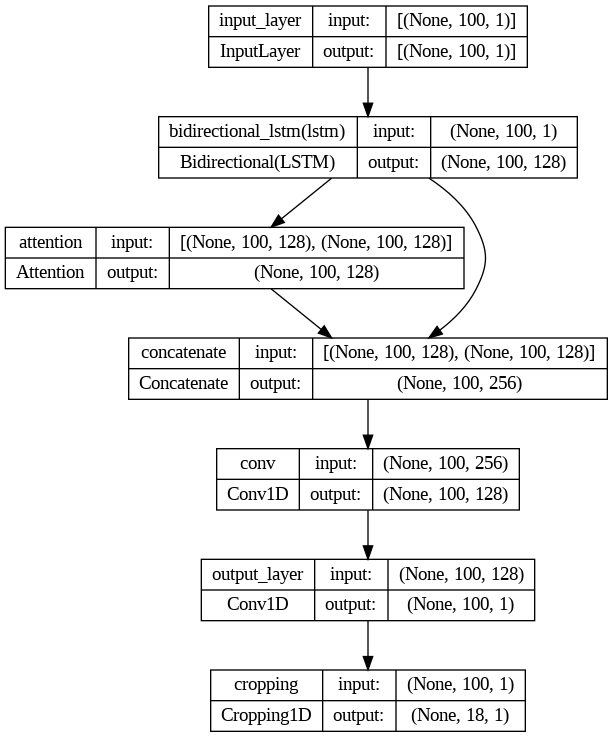

In [ ]:
model = build_CONV_LSTM_attention_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=12, restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min", patience=10, factor=0.1, min_lr=1e-5
        ),
    ],
).history

Epoch 1/200
226/226 [==============================] - 15s 19ms/step - loss: 0.0333 - val_loss: 0.0240 - lr: 0.0010
Epoch 2/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0233 - val_loss: 0.0195 - lr: 0.0010
Epoch 3/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0195 - val_loss: 0.0178 - lr: 0.0010
Epoch 4/200
226/226 [==============================] - 3s 14ms/step - loss: 0.0169 - val_loss: 0.0161 - lr: 0.0010
Epoch 5/200
226/226 [==============================] - 4s 16ms/step - loss: 0.0151 - val_loss: 0.0145 - lr: 0.0010
Epoch 6/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0146 - val_loss: 0.0149 - lr: 0.0010
Epoch 7/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0144 - val_loss: 0.0153 - lr: 0.0010
Epoch 8/200
226/226 [==============================] - 3s 12ms/step - loss: 0.0138 - val_loss: 0.0135 - lr: 0.0010
Epoch 9/200
226/226 [==============================] - 3s 13ms/step - loss: 0.0

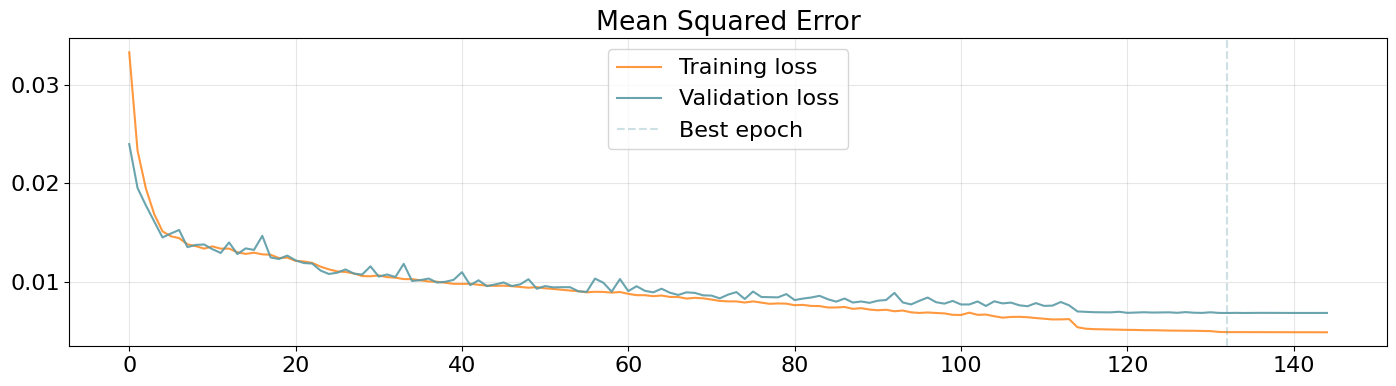

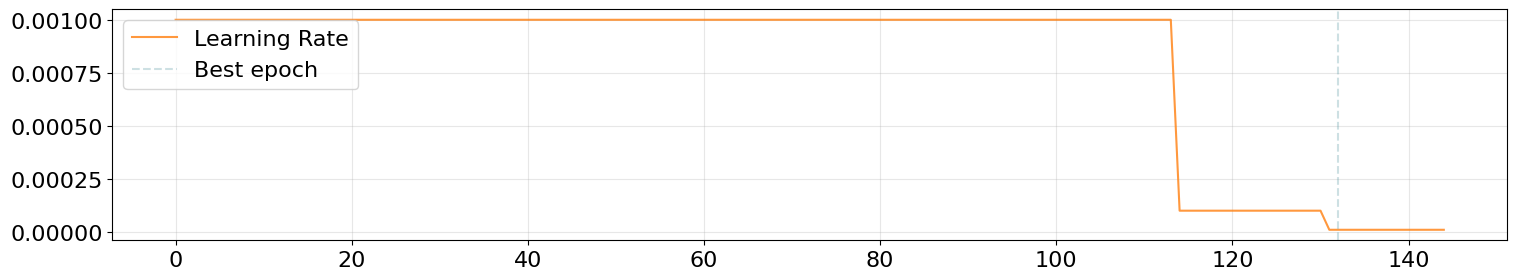

In [ ]:
best_epoch = np.argmin(history["val_loss"])
plt.figure(figsize=(17, 4))
plt.plot(history["loss"], label="Training loss", alpha=0.8, color="#ff7f0e")
plt.plot(history["val_loss"], label="Validation loss", alpha=0.9, color="#5a9aa5")
plt.axvline(x=best_epoch, label="Best epoch", alpha=0.3, ls="--", color="#5a9aa5")
plt.title("Mean Squared Error")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history["lr"], label="Learning Rate", alpha=0.8, color="#ff7f0e")
plt.axvline(x=best_epoch, label="Best epoch", alpha=0.3, ls="--", color="#5a9aa5")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(
    y_test.flatten(), predictions.flatten()
).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(
    y_test.flatten(), predictions.flatten()
).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (4011, 18, 1)
Mean Squared Error: 0.006757726892828941
Mean Absolute Error: 0.0544213131070137


In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:, i, j] - predictions[:, i, j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(X_test, verbose=0)
#Pad the predictions with Nand to shift them in time
result = np.concatenate(
    (X_test, future_predictions), axis=1
)

# Create a list from WINDOW_SIZE to the end of the predictions
idxs = np.arange(WINDOW_SIZE, WINDOW_SIZE + TELESCOPE)

print(result.shape)
print(maes.shape)
print(idxs.shape)

(4011, 118, 1)
(18, 1)
(18,)


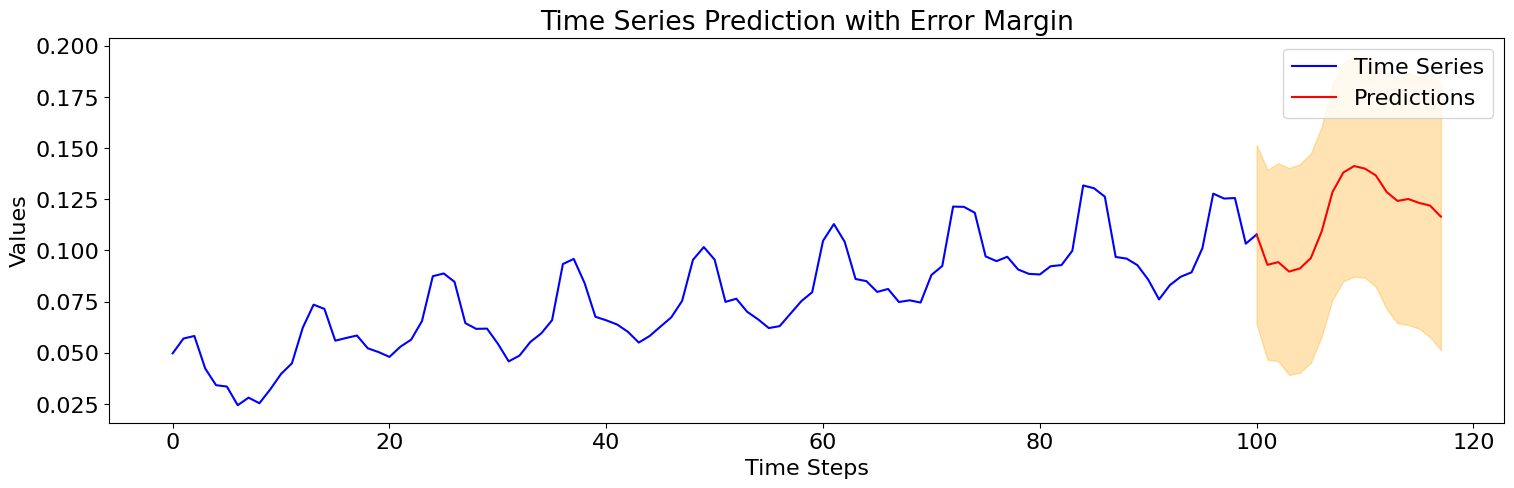

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(result[0, :WINDOW_SIZE + 1, 0], color='blue', label='Time Series')
ax.plot(idxs,result[0, :, 0][-18:], color='red', label='Predictions')

ax.fill_between(
    idxs,
    future_predictions[0, :, 0] - maes[:, 0],
    future_predictions[0, :, 0] + maes[:, 0],
    alpha=0.3,
    color='orange',
)


ax.legend()
ax.set_title('Time Series Prediction with Error Margin')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Values')

plt.show()

In [ ]:
# Save the model
model.save("./Models/Model_A")